## makemore - MLP v2, closer look

This implementation includes:
- Multiple layers
- Diagnostics and visualizations
- BatchNorm

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import random
import numpy as np

names = open('data/names.txt', 'r').read().splitlines()
print("Sample names: ", names[5:12])
print("Number of names: ", len(names))

# create char to index mapping for set (vocabulary) of chars in names
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print("Character mapping: ", itos)
print("Vocab Size: ", vocab_size)

Sample names:  ['charlotte', 'mia', 'amelia', 'harper', 'evelyn', 'abigail', 'emily']
Number of names:  32033
Character mapping:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocab Size:  27


In [19]:
# building dataset

def build_dataset(names):
    context_length = 3 
    X, Y = [], []
    for name in names:

        context = [0] * context_length 
        for char in name + '.':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

random.seed(1337)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtrain, Ytrain = build_dataset(names[:n1])  # 80%
Xval, Yval = build_dataset(names[n1:n2])    # 10%
Xtest, Ytest = build_dataset(names[n2:])    # 10%

torch.Size([182383, 3]) torch.Size([182383])
torch.Size([22883, 3]) torch.Size([22883])
torch.Size([22882, 3]) torch.Size([22882])


In [25]:
# constructing network 

dim_embed = 10
hidden_layer_size = 200
context_length = 3

g = torch.Generator().manual_seed(978467474)
C = torch.randn((vocab_size, dim_embed),                            generator=g)
W1 = torch.randn((dim_embed * context_length, hidden_layer_size),   generator=g) 
b1 = torch.randn(hidden_layer_size,                                 generator=g)
W2 = torch.randn((hidden_layer_size, vocab_size),                   generator=g)
b2 = torch.randn(vocab_size,                                        generator=g)

parameters = [C, W1, b1, W2, b2] # all parameters of the model
print(sum(p.nelement() for p in parameters)) # number of parameters in the model
for p in parameters:
    p.requires_grad = True

11897


In [26]:
# training loop

def train(steps, lr, batch_size=32):
    batch_losses = []  # added here to capture loss later when we scale up neuron count
    for _ in range(steps):

        # batch
        ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
        Xb, Yb = Xtrain[ix], Ytrain[ix]

        # forward pass 
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        hpreact = embcat @ W1 + b1 # hidden layer pre-activation
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        with torch.no_grad(): # no graph tracking for the update step
            for p in parameters:
                p.add_(p.grad, alpha=-lr)  # in-place, safe under no_grad

        batch_losses.append(loss.item())
    return batch_losses # added return here to capture loss later when we scale up neuron count

    # print(loss.item()) # loss per batch 

# whole-dataset evaluation helper (old)
@torch.no_grad() # decorator that disables gradient tracking
def evaluate(X, Y):
    emb = C[X] 
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1 
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y) 
    return loss.item()

# split evaluation helper (new)
@torch.no_grad() # decorator that disables gradient tracking
def split_evaluate(split):
    x,y = {
        'train': (Xtrain, Ytrain),
        'val': (Xval, Yval),
        'test': (Xtest, Ytest)
    }[split]

    emb = C[x] 
    embcat = emb.view(emb.shape[0], -1) 
    h = torch.tanh(embcat @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y) 
    return loss.item()


In [27]:
# training

# track training loss
train_loss = []     # per epoch now
val_loss = []       # per epoch

# training parameters
epochs = 200
steps_per_epoch = 1000
learning_rate = 0.1

for epoch in range (epochs): 
    if epoch == 80: learning_rate = 0.01 # hacky learning rate decay
    if epoch == 150: learning_rate = 0.005 # hacky learning rate decay

    train(steps_per_epoch, learning_rate, batch_size=64) 
    train_loss.append(split_evaluate('train')) # capture train loss at epoch end rather than mini-batch loss
    val_loss.append(split_evaluate('val'))

    if epoch % 20 == 0: print(f"Epoch {epoch}: val loss {val_loss[-1]}")

Epoch 0: val loss 3.2803993225097656
Epoch 20: val loss 2.4146759510040283
Epoch 40: val loss 2.3154537677764893
Epoch 60: val loss 2.3543806076049805
Epoch 80: val loss 2.2085726261138916
Epoch 100: val loss 2.199052333831787
Epoch 120: val loss 2.1966392993927
Epoch 140: val loss 2.1950736045837402
Epoch 160: val loss 2.1913692951202393
Epoch 180: val loss 2.1896486282348633


=== Loss summary ===
Train — last: 2.1386  (epoch 200)
Train —  min:  2.1385  (epoch 197)
Val   — last: 2.1887     (epoch 200)
Val   —  min:  2.1880     (epoch 195)


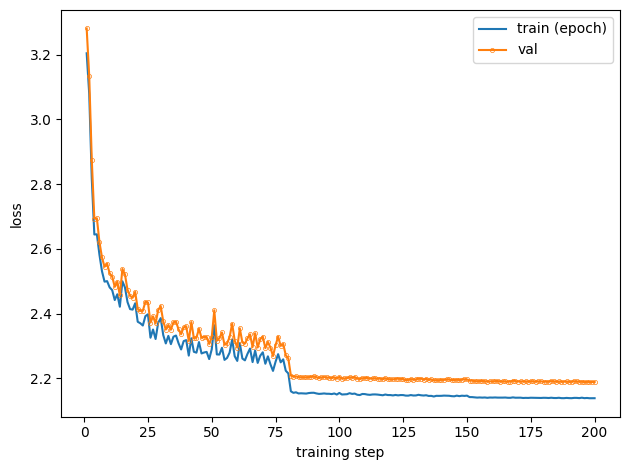

In [28]:
# showing training results

E = len (train_loss)      # number of epochs
xs = np.arange(1, E+1)


# --- plot (epoch-level curves) ---
plt.figure()
plt.plot(xs, train_loss, label='train (epoch)')
plt.plot(xs, val_loss, marker='o', ms=3, mew=0.5, mfc='none', mec='auto', label='val')
plt.xlabel('training step'); plt.ylabel('loss'); plt.legend(); plt.tight_layout()


ti = int(np.argmin(train_loss))   # index of min train loss (epoch-level)
vi = int(np.argmin(val_loss))     # index of min val loss (epoch-level)

print("=== Loss summary ===")
print(f"Train — last: {train_loss[-1]:.4f}  (epoch {E})")
print(f"Train —  min:  {train_loss[ti]:.4f}  (epoch {ti})")

print(f"Val   — last: {val_loss[-1]:.4f}     (epoch {E})")
print(f"Val   —  min:  {val_loss[vi]:.4f}     (epoch {vi})")


In [29]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * context_length # initializes with all '.' chars 
    while True:
      emb = C[torch.tensor([context])]
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item() # sample
      context = context[1:] + [ix] # slide window
      out.append(ix)
      if ix == 0: # break on end token '.'
        break
    
    print(''.join(itos[i] for i in out))

onpneyah.
valaniya.
naa.
aili.
gialeydesha.
jenzalia.
abihaylan.
dieskashlas.
theya.
aziyari.
bradharron.
adyn.
jessan.
saylontees.
art.
yuh.
abdopo.
rerby.
renyse.
amma.
